In [47]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import time
from tqdm import tqdm
import tensorflow as tf

from tfGCN.models import GCN, HashedGCN
from tfGCN.utils import *

In [2]:
# Set random seed
seed = 123

In [3]:
# Settings
flags = tf.app.flags 
FLAGS = tf.app.flags.FLAGS
flags.DEFINE_string('dataset', 'cora', 'Dataset string.')  # 'cora', 'citeseer', 'pubmed'
flags.DEFINE_string('model', 'gcn', 'Model string.')  # 'gcn', 'gcn_cheby', 'hashed_gcn', 'dense'
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.5, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 5e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
flags.DEFINE_integer('compression_factor1', 1, 'Hashed GCN weight compression factor (layer 1).')
flags.DEFINE_integer('compression_factor2', 1, 'Hashed GCN weight compression factor (layer 2).')
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [4]:
# Load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(FLAGS.dataset)

# Some preprocessing
features = preprocess_features(features)

support = [preprocess_adj(adj)]
num_supports = 1

In [5]:
# Define placeholders
placeholders = {
    'support': [tf.sparse_placeholder(tf.float32) for _ in range(num_supports)],
    'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(features[2], dtype=tf.int64)),
    'labels': tf.placeholder(tf.float32, shape=(None, y_train.shape[1])),
    'labels_mask': tf.placeholder(tf.int32),
    'dropout': tf.placeholder_with_default(0., shape=()),
    'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
}

In [13]:
# Define model evaluation function
def evaluate(features, support, labels, mask, placeholders):
    t_test = time.time()
    feed_dict_val = construct_feed_dict(features, support, labels, mask, placeholders)
    outs_val = sess.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

In [78]:
model = GCN(placeholders, input_dim=features[2][1], logging=True)

In [89]:
# Reseed
np.random.seed(seed)
tf.set_random_seed(seed)

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [90]:
cost_val = []

# Train model
for epoch in range(FLAGS.epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})

    # Training step
    outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

    # Validation
    cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
    cost_val.append(cost)

#     # Print results
#     print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(outs[1]),
#           "train_acc=", "{:.5f}".format(outs[2]), "val_loss=", "{:.5f}".format(cost),
#           "val_acc=", "{:.5f}".format(acc), "time=", "{:.5f}".format(time.time() - t))

    if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
        print("Early stopping...")
        break
        
_, baseline_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
print("Baseline accuracy:", baseline_acc)

Baseline accuracy: 0.80899906


In [145]:
compression_factors = [1, 2, 4, 8, 16, 32, 64, 128]
compression_accuracies = []
num_runs = 5

for cf in tqdm(compression_factors):
    FLAGS.compression_factor1 = cf
    FLAGS.compression_factor2 = 1
    np.random.seed(seed)
    tf.set_random_seed(seed)
    all_acc = []
    
    for _ in range(num_runs):
        model = HashedGCN(placeholders, input_dim=features[2][1], logging=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        cost_val = []
        # Train model
        for epoch in range(FLAGS.epochs):
            t = time.time()

            feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
            feed_dict.update({placeholders['dropout']: FLAGS.dropout})

            # Training step
            outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

            # Validation
            cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
            cost_val.append(cost)

            if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
                break
        _, compressed_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
        all_acc.append(compressed_acc)
    compression_accuracies.append(np.median(all_acc))
compression_accuracies = np.asarray(compression_accuracies)



  0%|                                                    | 0/8 [00:00<?, ?it/s]

 12%|█████▍                                     | 1/8 [04:09<29:08, 249.83s/it]

 25%|██████████▊                                | 2/8 [08:30<25:18, 253.14s/it]

 38%|████████████████▏                          | 3/8 [12:57<21:26, 257.26s/it]

 50%|█████████████████████▌                     | 4/8 [17:30<17:27, 261.83s/it]

 62%|██████████████████████████▉                | 5/8 [22:16<13:27, 269.18s/it]

 75%|████████████████████████████████▎          | 6/8 [27:10<09:13, 276.63s/it]

 88%|█████████████████████████████████████▋     | 7/8 [32:16<04:45, 285.35s/it]

100%|███████████████████████████████████████████| 8/8 [37:28<00:00, 293.42s/it]



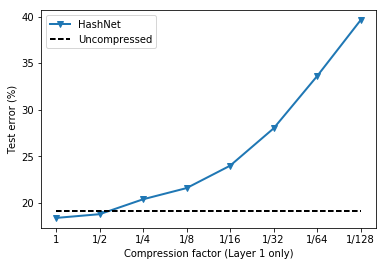

In [146]:
# Plot compression vs accuracy
x = np.arange(8)
plt.xlabel("Compression factor (Layer 1 only)")
plt.ylabel("Test error (%)")
plt.plot(x, (1 - compression_accuracies) * 100, label="HashNet", linewidth=2.0, marker='v')
fig = plt.plot(x, (1 - np.repeat(baseline_acc, 8)) * 100, label="Uncompressed", linewidth=2.0, linestyle='--', color='black')
plt.xticks(x, ["1", "1/2", "1/4", "1/8", "1/16", "1/32", "1/64", "1/128"])
leg = plt.legend()

In [147]:
with open('compression_layer1.png','wb') as f:
    fig[0].figure.savefig(f, format='png', dpi=144)

In [137]:
compression_factors_base = [1, 2, 4, 8]
compression_factors_hashed = [1, 2, 4, 8, 16, 32]
num_runs = 5

base_compression_accuracies = []
both_layer_compression_accuracies = []
for cf in tqdm(compression_factors_base):
    FLAGS.hidden1 = 16 // cf
    np.random.seed(seed)
    tf.set_random_seed(seed)
    all_acc = []
    for _ in range(num_runs):
        model = GCN(placeholders, input_dim=features[2][1], logging=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        cost_val = []
        # Train model
        for epoch in range(FLAGS.epochs):
            t = time.time()

            feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
            feed_dict.update({placeholders['dropout']: FLAGS.dropout})

            # Training step
            outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

            # Validation
            cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
            cost_val.append(cost)

            if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
                break
        _, compressed_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
        all_acc.append(compressed_acc)
    base_compression_accuracies.append(np.median(all_acc))

FLAGS.hidden1 = 16
    
for cf in tqdm(compression_factors_hashed):
    FLAGS.compression_factor1 = cf
    FLAGS.compression_factor2 = cf
    np.random.seed(seed)
    tf.set_random_seed(seed)
    all_acc = []
    for _ in range(num_runs):
        model = HashedGCN(placeholders, input_dim=features[2][1], logging=True)
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())

        cost_val = []
        # Train model
        for epoch in range(FLAGS.epochs):
            t = time.time()

            feed_dict = construct_feed_dict(features, support, y_train, train_mask, placeholders)
            feed_dict.update({placeholders['dropout']: FLAGS.dropout})

            # Training step
            outs = sess.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)

            # Validation
            cost, acc, duration = evaluate(features, support, y_val, val_mask, placeholders)
            cost_val.append(cost)

            if epoch > FLAGS.early_stopping and cost_val[-1] > np.mean(cost_val[-(FLAGS.early_stopping+1):-1]):
                break
        _, compressed_acc, _ = evaluate(features, support, y_test, test_mask, placeholders)
        all_acc.append(compressed_acc)
    both_layer_compression_accuracies.append(np.median(all_acc))
    
base_compression_accuracies = np.asarray(base_compression_accuracies)
both_layer_compression_accuracies = np.asarray(both_layer_compression_accuracies)


100%|███████████████████████████████████████████| 4/4 [08:02<00:00, 123.55s/it]

100%|███████████████████████████████████████████| 6/6 [17:06<00:00, 170.34s/it]


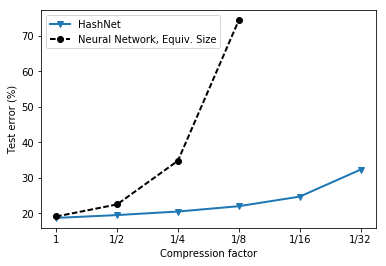

In [140]:
# Plot comparison between hashed and equiv size unhashed
x = np.arange(len(compression_factors_hashed))
plt.xlabel("Compression factor")
plt.ylabel("Test error (%)")
plt.plot(x, (1 - both_layer_compression_accuracies) * 100, label="HashNet", linewidth=2.0, marker='v')
fig = plt.plot(x[:len(compression_factors_base)], (1 - base_compression_accuracies) * 100, label="Neural Network, Equiv. Size", \
         linewidth=2.0, marker='o', linestyle='--', color='black')
plt.xticks(x, ["1", "1/2", "1/4", "1/8", "1/16", "1/32", "1/64", "1/128"])
leg = plt.legend()

In [141]:
with open('compression_equiv.png','wb') as f:
    fig[0].figure.savefig(f, format='png', dpi=144)